# Pandas loading and data cleaning

In [1]:
import numpy as np
import pandas as pd
import datetime
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

from itertools import combinations
from scipy.stats import ttest_ind

sns.set(style="darkgrid")
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('main_task.csv')

## Dataset Features:

- City: name of city
- Cuisine Style: type of cuisine
- Ranking: Restaurant rank realting ot other restaurants in that city
- Price Range: prices in the restaurant in three catogories
- Number of Reviews: total number of reviews
- Reviews: two last reviews with dates of reviews
- URL_TA: website of the restaurant at 'www.tripadvisor.com'
- ID_TA: ID of the restaurant at TripAdvisor
- Rating: restaurant rating

NaNs for every column in the set

In [3]:
for col in df.columns:
    print(col, str(round(100 * df[col].isnull().sum() / len(df), 2)) + '%')

Restaurant_id 0.0%
City 0.0%
Cuisine Style 23.21%
Ranking 0.0%
Rating 0.0%
Price Range 34.72%
Number of Reviews 6.36%
Reviews 0.0%
URL_TA 0.0%
ID_TA 0.0%


In [4]:
# changing name of columns for convinience
df = df.rename(
    columns={
        "Restaurant_id": "rest_id",
        "City": "city",
        "Cuisine Style": "cuisine_style",
        "Price Range": "price_range",
        "Reviews": "reviews",
        "Ranking": "ranking",
        "Rating": "rating",
        "Number of Reviews": "num_of_reviews"
    })

In [5]:
df.sample(5)

,rest_id,city,cuisine_style,ranking,rating,price_range,num_of_reviews,reviews,URL_TA,ID_TA
5848,id_9161,Paris,"['French', 'Wine Bar', 'Spanish']",9163.0,4.5,$$ - $$$,30.0,"[['Wine +food = exquisite', 'Great hygge place...",/Restaurant_Review-g187147-d7377732-Reviews-Au...,d7377732
38991,id_1007,Warsaw,"['Polish', 'European']",1008.0,5.0,NaN,4.0,"[['Degrengolada'], ['11/04/2016']]",/Restaurant_Review-g274856-d10627712-Reviews-B...,d10627712
8800,id_1233,Geneva,NaN,1239.0,3.0,NaN,7.0,"[['Very bad', 'Good local café with reasonably...",/Restaurant_Review-g188057-d10619018-Reviews-R...,d10619018
24074,id_150,Stockholm,"['European', 'Contemporary', 'Swedish', 'Scand...",151.0,4.5,$$$$,59.0,"[['experimenting in realtime', 'Swedish with a...",/Restaurant_Review-g189852-d9715611-Reviews-Ag...,d9715611
31156,id_2682,Munich,NaN,2703.0,2.5,NaN,9.0,"[['Nice for drinks and something to eat'], ['0...",/Restaurant_Review-g187309-d10389328-Reviews-P...,d10389328


## EDA

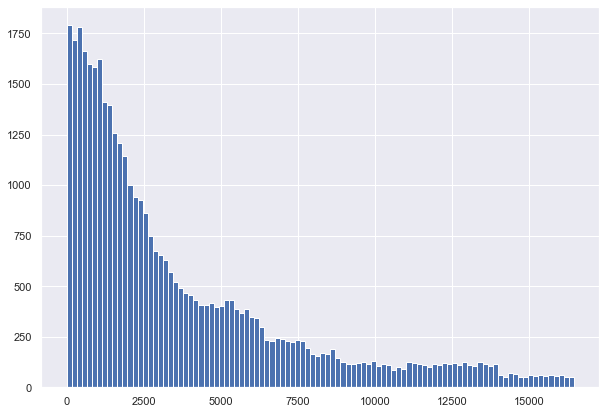

In [6]:
plt.rcParams['figure.figsize'] = (10, 7)
df['ranking'].hist(bins=100)

There are many restaurants with low rank, less then 3000

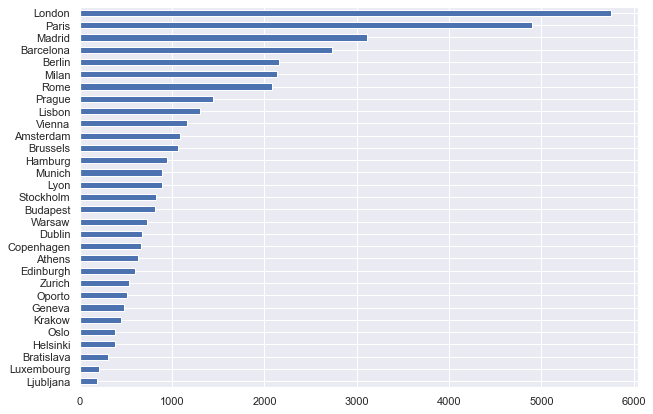

In [7]:
df['city'].value_counts(ascending=True).plot(kind='barh')

The biggest amount of restaurants in London

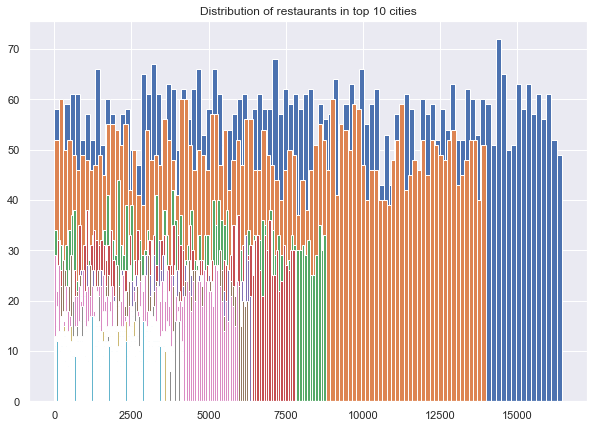

In [8]:
for x in (df['city'].value_counts())[0:10].index:
    df['ranking'][df['city'] == x].hist(bins=100)
plt.title('Distribution of restaurants in top 10 cities')
plt.show()

Ranking has a normal distribution. Th shift is only dut to more restaurants in big cities.

It makes sense to create a new feature which put all rankings to the same common value.

Checking the distribution of target value vs rank of the restaurant

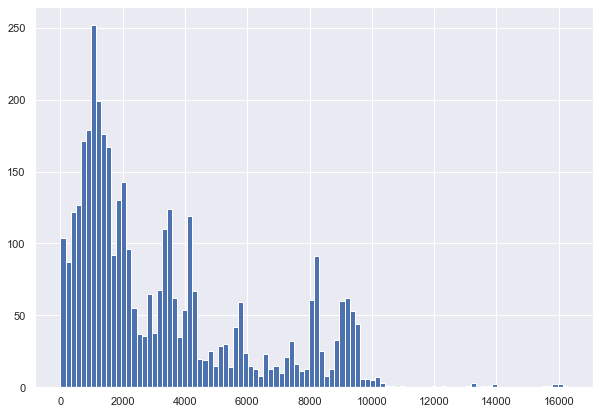

In [9]:
df['ranking'][df['rating'] == 5].hist(bins=100)

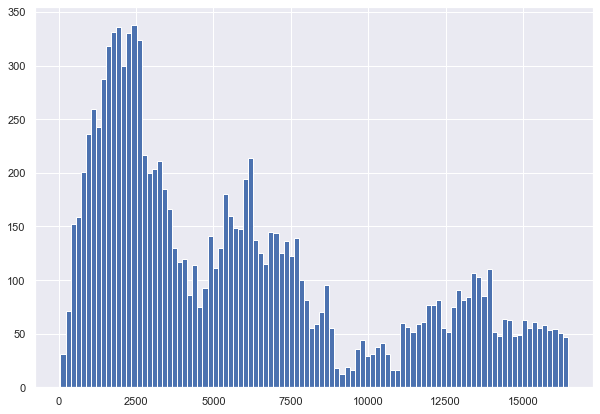

In [10]:
df['ranking'][df['rating'] < 4].hist(bins=100)

Distribution is assymetrical, rigth shifted. Mostly ranking is lower then 4000 

Correlative analysis

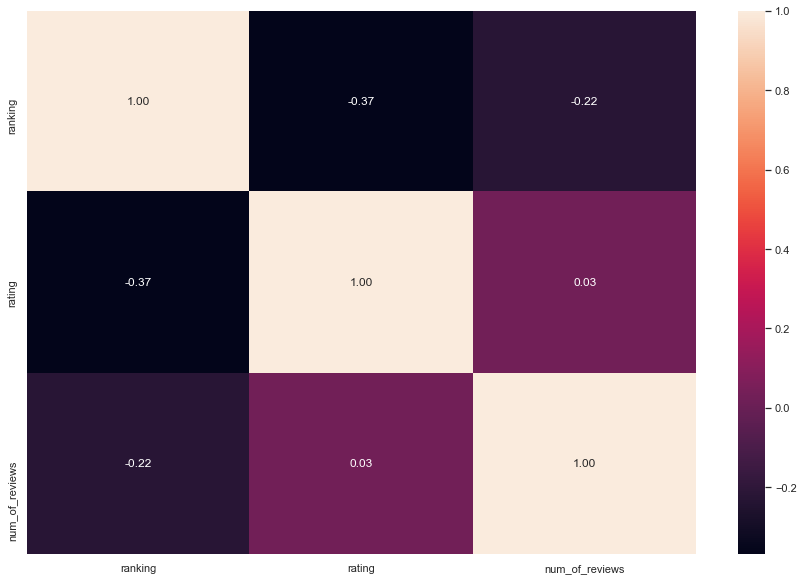

In [11]:
sns.set()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, ax=ax, fmt=".2f")

All features are correlated badly and will be used for model. It is also good to do correlation later, fater feature engineering

## Cleaning and Preparing Data

In [12]:
# replacing of price range to more undestandable names and
# filling in NaNs to 2 as it is the most frequent

df['price_range'] = df['price_range'].replace({
    '$': 'low',
    '$$ - $$$': 'middle',
    '$$$$': 'high'
})

df['price_range'] = df['price_range'].fillna('middle')

In [13]:
# filling Nan
df['num_of_reviews_isNAN'] = pd.isna(df['num_of_reviews']).astype('uint8')
df['num_of_reviews'].fillna(0, inplace=True)
df.cuisine_style = df.cuisine_style.fillna('unk')
df['reviews'] = df['reviews'].fillna('no review')

## Feature engineering

In [14]:
# creating a new column to show how many cuisines are in the restaurant, filling nan by 1
df['cuisine_count'] = df['cuisine_style'].str.findall(
    r'\w+\s*\w*\s*\w*').apply(lambda x: 1 if (x == 'unk') else len(x))

In [15]:
# working with dates from Reviews to create new feature on difference between the dates

def reviews_date(rew, count): # function getting date from string
    date = re.findall(r'\d\d?/\d\d?/\d+', rew)
    if len(date) == 0:
        return np.nan
    if count == 1:
        return pd.to_datetime(date[0])
    elif len(date) == 2:
        return pd.to_datetime(date[1])
    else:
        return np.nan

df['rev_date_dif'] = df['reviews'].apply(lambda x: reviews_date(
    x, 1)) - df['reviews'].apply(lambda x: reviews_date(x, 2))

df['rev_date_dif'] = df['rev_date_dif'].fillna(df['rev_date_dif'].mean())

df['rev_date_dif'] = df['rev_date_dif'].apply(  # new column reflects how many days are between reviews
    lambda x: pd.to_timedelta(x).days)

In [16]:
# creating a new column which express the rating of restaurant based on mean rating for this city
df['ranking_city'] = 0
for item in df['city'].unique():
    cr_mean = df['ranking'].loc[df['city'] == item].mean()
    df['ranking_city'].loc[df['city'] == item] = cr_mean
df['ranking_city'] = df['ranking_city'] / df['ranking']

In [17]:
# Adding external data about cities created by MaxMind, available from http://www.maxmind.com/
cities = pd.read_csv('worldcitiespop.csv')
cities.sample(5)

,Country,City,AccentCity,Region,Population,Latitude,Longitude
1987768,ng,dan kuliya,Dan Kuliya,24,NaN,12.740533,8.731722
2066881,pe,copacabana hacienda,Copacabana Hacienda,15,NaN,-11.850000,-77.100000
390220,ch,trogen,Trogen,15,NaN,47.408413,9.464493
910576,fi,skriko,Skriko,15,NaN,63.750000,23.383333
2939168,us,golden gate,Golden Gate,IL,NaN,38.359444,-88.204167


In [18]:
# making list of cities available at df with there population taking from cities
city_list = {}
for city in df.city.unique():
    city_list[city] = cities.Population[(cities.AccentCity == city) & (cities.Population.isnull() == False)].max() 

In [19]:
city_list

{'Paris': 2110694.0,
 'Stockholm': 1253309.0,
 'London': 7421228.0,
 'Berlin': 3398362.0,
 'Munich': 1246133.0,
 'Oporto': nan,
 'Milan': 1156903.0,
 'Bratislava': 423737.0,
 'Vienna': 1569315.0,
 'Rome': 2643736.0,
 'Barcelona': 1570378.0,
 'Madrid': 3102644.0,
 'Dublin': 1024027.0,
 'Brussels': 1019022.0,
 'Zurich': 346185.0,
 'Warsaw': 1651676.0,
 'Budapest': 1708088.0,
 'Copenhagen': 1089958.0,
 'Amsterdam': 745811.0,
 'Lyon': 463700.0,
 'Hamburg': 1733846.0,
 'Lisbon': 517798.0,
 'Prague': 1154508.0,
 'Oslo': 808690.0,
 'Helsinki': 558457.0,
 'Edinburgh': 435794.0,
 'Geneva': 181492.0,
 'Ljubljana': 255115.0,
 'Athens': 729139.0,
 'Luxembourg': nan,
 'Krakow': nan}

In [20]:
# there are 3 nan values which are filled using data from Google
city_list['Krakow'] = 766683
city_list['Luxembourg'] = 625978
city_list['Oporto'] = 1313000
city_list

{'Paris': 2110694.0,
 'Stockholm': 1253309.0,
 'London': 7421228.0,
 'Berlin': 3398362.0,
 'Munich': 1246133.0,
 'Oporto': 1313000,
 'Milan': 1156903.0,
 'Bratislava': 423737.0,
 'Vienna': 1569315.0,
 'Rome': 2643736.0,
 'Barcelona': 1570378.0,
 'Madrid': 3102644.0,
 'Dublin': 1024027.0,
 'Brussels': 1019022.0,
 'Zurich': 346185.0,
 'Warsaw': 1651676.0,
 'Budapest': 1708088.0,
 'Copenhagen': 1089958.0,
 'Amsterdam': 745811.0,
 'Lyon': 463700.0,
 'Hamburg': 1733846.0,
 'Lisbon': 517798.0,
 'Prague': 1154508.0,
 'Oslo': 808690.0,
 'Helsinki': 558457.0,
 'Edinburgh': 435794.0,
 'Geneva': 181492.0,
 'Ljubljana': 255115.0,
 'Athens': 729139.0,
 'Luxembourg': 625978,
 'Krakow': 766683}

In [21]:
# making new column in df with population for each city
df['pop_ranking'] = 0
for item in df['city'].unique():
    df['pop_ranking'].loc[df['city'] == item] = city_list[item]

# new column reflects ratio between amount of population and rankig of the restaurant    
df['pop_ranking'] = df['pop_ranking']/df['ranking']

df.sample(5)

,rest_id,city,cuisine_style,ranking,rating,price_range,num_of_reviews,reviews,URL_TA,ID_TA,num_of_reviews_isNAN,cuisine_count,rev_date_dif,ranking_city,pop_ranking
10498,id_1311,Amsterdam,"['Mediterranean', 'Turkish', 'Middle Eastern',...",1314.0,4.0,middle,48.0,"[['so tasty', 'Superb Turkish Cuisine'], ['11/...",/Restaurant_Review-g188590-d3539613-Reviews-Re...,d3539613,0,5,55,1.203154,567.588280
26381,id_10365,London,"['Indian', 'Asian', 'Balti', 'Eastern European...",10374.0,3.5,middle,41.0,"[['Friends meeting', 'Very good food. Could be...",/Restaurant_Review-g186338-d1044624-Reviews-Sa...,d1044624,0,5,106,0.790289,715.368035
322,id_5916,London,unk,5925.0,4.0,middle,56.0,"[['Fab', 'Nice concept - good food'], ['11/22/...",/Restaurant_Review-g186338-d6672773-Reviews-Hi...,d6672773,0,1,180,1.383707,1252.527932
20939,id_1596,Barcelona,"['Vegetarian Friendly', 'Vegan Options', 'Glut...",1597.0,4.0,low,111.0,"[['Good Vegeterian joint', 'Very filling vegan...",/Restaurant_Review-g187497-d10673747-Reviews-V...,d10673747,0,3,48,2.450936,983.329994
1407,id_1935,Brussels,unk,1936.0,4.5,middle,2.0,[['Excellent restaurant and very friendly ser....,/Restaurant_Review-g188644-d7284551-Reviews-Re...,d7284551,0,1,124,0.793051,526.354339


In [22]:
# One-Hot Encoding - creating dummies from price range and city
for cat in ['price_range','city']:
    df = pd.concat([df, pd.get_dummies(df[cat], prefix=cat)], axis=1)
    df = df.drop([cat], axis=1)

In [23]:
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df.drop(object_columns, axis=1, inplace=True)

In [24]:
df.head()

,ranking,rating,num_of_reviews,num_of_reviews_isNAN,cuisine_count,rev_date_dif,ranking_city,pop_ranking,price_range_high,price_range_low,price_range_middle,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
0,5570.0,3.5,194.0,0,3,41,1.244706,378.939677,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1537.0,4.0,10.0,0,1,382,0.808319,815.425504,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,353.0,4.5,688.0,0,7,2,23.225104,21023.308782,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3458.0,5.0,3.0,0,1,124,0.944545,982.753615,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,621.0,4.0,84.0,0,3,272,2.206988,2006.655395,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [25]:
df.corr()

,ranking,rating,num_of_reviews,num_of_reviews_isNAN,cuisine_count,rev_date_dif,ranking_city,pop_ranking,price_range_high,price_range_low,price_range_middle,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
ranking,1.000000,-0.368371,-0.222072,0.094078,-0.320111,0.099958,-0.060681,-0.056399,-0.088410,-0.014270,0.054696,-0.094372,-0.095177,0.017390,-0.026367,-0.075669,-0.095232,-0.095534,-0.094270,-0.094965,-0.092951,-0.088282,-0.097555,-0.081664,-0.087357,-0.088900,-0.062811,0.499991,-0.065863,-0.096448,0.055754,-0.036981,-0.093938,-0.090281,-0.082608,0.328009,-0.083389,-0.043718,-0.094931,-0.092039,-0.095860,-0.091098
rating,-0.368371,1.000000,0.026924,0.008386,0.120134,-0.045509,0.057634,0.052649,0.060862,0.064128,-0.087754,0.034535,0.044792,-0.012890,0.046967,-0.002988,-0.020753,0.020950,-0.001443,0.013431,0.017489,-0.005027,0.006539,-0.006737,0.024333,0.014565,0.012068,-0.023273,-0.008559,-0.010079,-0.083462,-0.059704,0.012207,0.031603,-0.014680,-0.028288,0.011442,0.083082,-0.026604,0.022037,0.019617,0.008197
num_of_reviews,-0.222072,0.026924,1.000000,-0.105853,0.405577,-0.146466,0.120284,0.112196,0.170603,-0.037351,-0.045683,0.013348,-0.010741,0.006194,-0.046995,-0.021603,-0.019411,0.014622,-0.014015,0.014049,0.046421,-0.022664,-0.040165,-0.020438,-0.001451,0.000857,-0.011259,0.018121,-0.010055,-0.018311,-0.023252,0.039952,-0.021808,0.003872,-0.009129,-0.002907,-0.004504,0.133542,-0.022549,-0.024217,-0.027845,-0.017892
num_of_reviews_isNAN,0.094078,0.008386,-0.105853,1.000000,-0.175377,-0.000087,-0.017074,-0.015349,-0.032895,-0.063426,0.073969,-0.012005,-0.000762,0.005354,0.030405,0.028294,0.002941,0.010961,-0.004746,-0.006999,-0.017668,0.004155,0.010548,0.000102,-0.000160,0.001359,0.005110,-0.004963,-0.000497,-0.010901,-0.001757,-0.014869,0.005706,0.002173,-0.005747,-0.027298,0.038056,-0.033754,0.007136,0.015148,0.022076,-0.001070
cuisine_count,-0.320111,0.120134,0.405577,-0.175377,1.000000,-0.240090,0.088007,0.084260,0.129625,0.062380,-0.118443,0.063350,-0.002122,0.004088,-0.043825,-0.017745,-0.011327,0.049984,0.006862,0.047888,0.079330,0.000049,-0.058847,-0.003593,0.032339,0.001647,0.025072,0.076488,0.002320,-0.082032,-0.085599,-0.014916,-0.013709,0.006656,0.022426,-0.094893,0.022730,0.075713,-0.009394,0.012730,-0.005442,0.024583
rev_date_dif,0.099958,-0.045509,-0.146466,-0.000087,-0.240090,1.000000,-0.034043,-0.031602,-0.045603,-0.007132,0.028002,-0.035873,-0.003703,0.000073,0.038809,0.010940,0.012438,-0.012942,-0.015635,-0.031271,-0.042946,0.002155,0.036771,0.000534,-0.009015,-0.005527,0.001470,-0.081833,0.002213,0.027018,0.019804,0.027875,0.012968,-0.012868,-0.004247,0.036173,0.000033,-0.000185,0.006548,0.011564,0.007763,0.006757
ranking_city,-0.060681,0.057634,0.120284,-0.017074,0.088007,-0.034043,1.000000,0.954311,0.069709,-0.004523,-0.028574,0.001998,-0.003985,-0.004847,-0.001352,-0.002652,-0.001859,0.000828,-0.002130,-0.003982,0.001765,-0.003353,-0.000545,-0.002937,-0.000627,0.000013,-0.001901,0.004807,-0.001454,-0.000665,0.008908,0.000967,-0.002470,-0.002691,0.000148,-0.002943,-0.001438,0.003694,0.002545,0.001718,0.001439,-0.002248
pop_ranking,-0.056399,0.052649,0.112196,-0.015349,0.084260,-0.031602,0.954311,1.000000,0.060436,-0.002884,-0.025730,-0.003175,-0.003065,-0.011135,0.004788,-0.001489,-0.002803,0.010157,0.001576,-0.001453,-0.001796,-0.006108,0.006873,-0.001356,0.003976,-0.008080,-0.000459,0.011251,0.004933,-0.005837,0.006496,-0.007872,-0.000457,0.005149,0.006455,-0.016563,-0.004450,0.006964,0.006618,0.004678,0.012922,-0.004540
price_range_high,-0.088410,0.060862,0.170603,-0.032895,0.129625,-0.045603,0.069709,0.060436,1.000000,-0.082877,-0.393300,-0.006340,-0.004

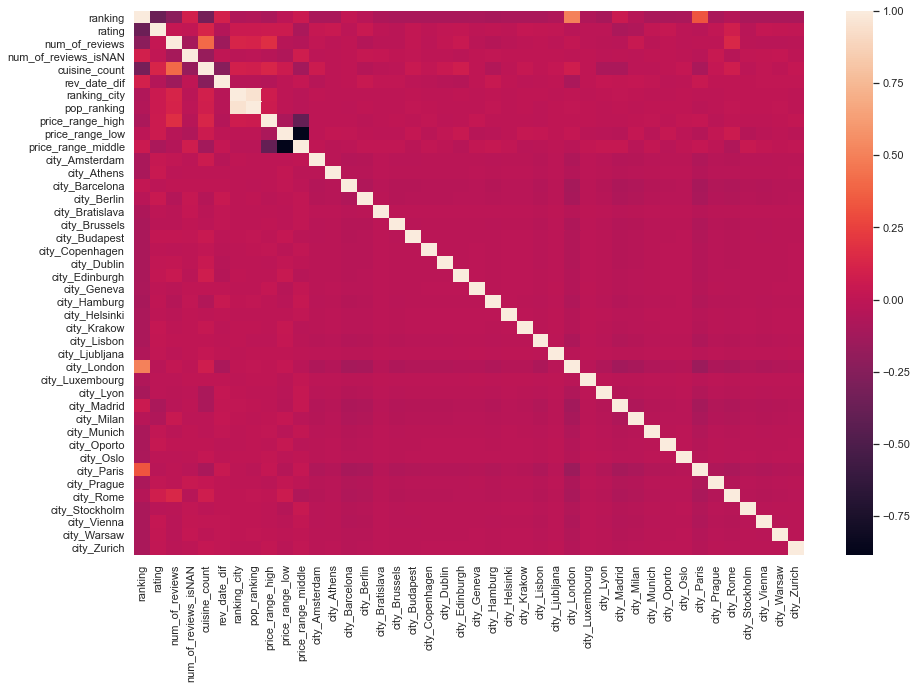

In [26]:
# another correlative analysis wiht all features
sns.set()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df.corr(), ax=ax, fmt=".2f")

We may see that all of fatures has low correlation with target value, except some new features for amount of population. 

# Split dataframe to two parts for model tarining and testing

In [27]:
# Х - restaurants data, у - target variable (restaurants rating)
X = df.drop(['rating'], axis = 1)
y = df['rating']

In [28]:
# import tools:
from sklearn.model_selection import train_test_split

In [29]:
# "train" data is for model training, "test" - for model testing.
# Fo testing is used 25% of origin dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Create, train and test the model

In [30]:
# labraries import
from sklearn.ensemble import RandomForestRegressor # tool for model training and testing
from sklearn import metrics # tool for evaluation of model

In [31]:
# model creating
regr = RandomForestRegressor(n_estimators=100)

# model training on test data
regr.fit(X_train, y_train)

# using of trained model for predication of restaurants rating in test data.
# Predicted values put in y_pred
y_pred = regr.predict(X_test)

In [32]:
# Compare predicted values (y_pred) with real (y_test), checking what is the medium difference
# Metrics called Mean Absolute Error (MAE) chows mean error for predicted values form real ones.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2080995


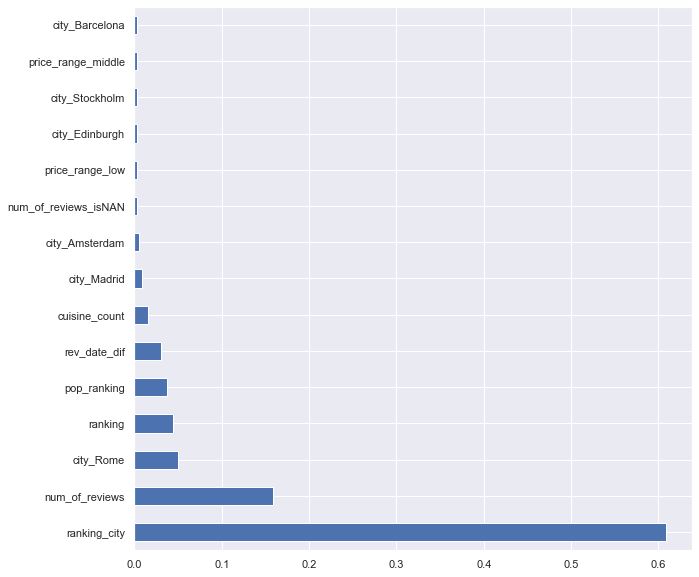

In [33]:
# lets see to the most important features for the model
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')